In [1]:
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, Y = datasets.load_iris(return_X_y=True)

In [3]:
import sklearn.decomposition as decomposition
import sklearn.preprocessing as preprocessing

In [4]:
pca = decomposition.PCA()
pca.fit(X)

PCA()

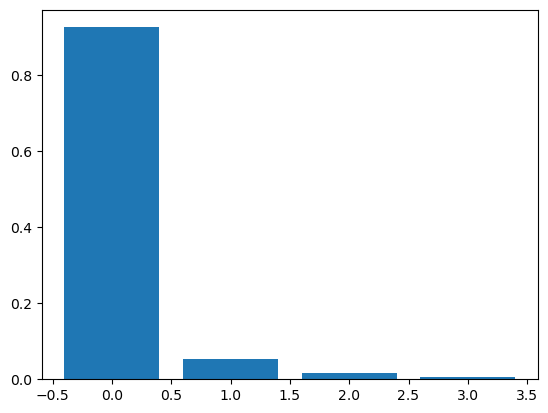

In [5]:
plt.bar(range(4), pca.explained_variance_ratio_)
plt.show()

In [6]:
U = pca.transform(X)
U = U[:,:2]

In [7]:
U2 = U[Y != 0]
Y2 = Y[Y != 0]

In [8]:
Y2[Y2 == 1] = -1
Y2[Y2 == 2] = +1

In [9]:
Y2 = Y2.astype('d')
N = len(Y2)

In [10]:
U2 = preprocessing.scale(U2)

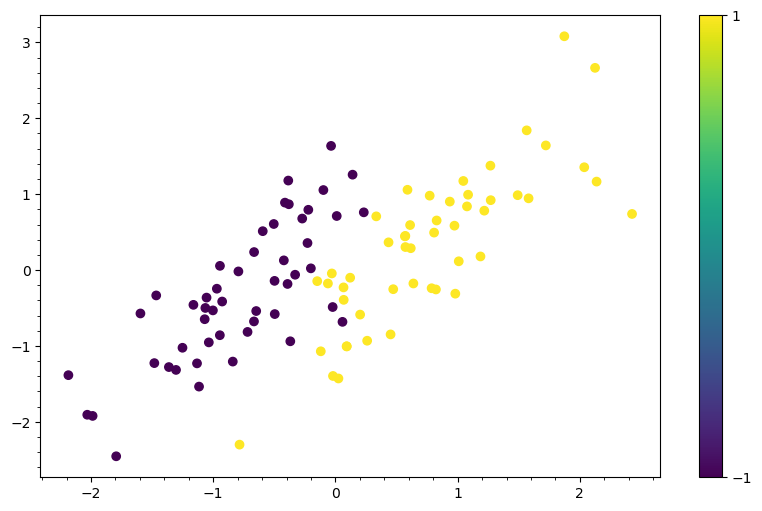

In [11]:
plt.figure(figsize=(10,6))
sc = plt.scatter(U2[:,0], U2[:,1], c=Y2)
plt.colorbar(sc,ticks=[-1,+1])
plt.minorticks_on()
plt.show()

In [12]:
import mlgrad.loss as loss
import mlgrad.funcs as funcs
import mlgrad.models as models
import mlgrad.funcs2 as funcs2
from mlgrad.cls import classification_erm
import mlgrad.plots as plots
import mlgrad.inventory as inventory
import mlgrad.gd as gd

In [13]:
n_hidden1 = 101
# n_hidden2 = 101
# n_hidden3 = 101
body = models.FFNetworkModel()
ll = models.LinearLayer(2, n_hidden1)
ll.use_regularizer(funcs2.AbsoluteNorm(), 0.01)
body.add(ll)
body.add(models.ScaleLayer(funcs.Sigmoidal(5.0), n_hidden1))
# body.add(models.LinearLayer(n_hidden1, n_hidden2))
# body.add(models.ScaleLayer(funcs.Sigmoidal(4.0), n_hidden2))
# body.add(models.LinearLayer(n_hidden2, n_hidden3))
# body.add(models.ScaleLayer(funcs.Sigmoidal(4.0), n_hidden3))
head = models.LinearModel(body.n_output)
head.use_regularizer(funcs2.AbsoluteNorm(), 0.01)
nnmod = models.FFNetworkFuncModel(head, body)

In [14]:
nnmod.allocate()
nnmod.init_param()

In [15]:
print(len(nnmod.param))

405


In [16]:
alg = classification_erm(U2, Y2, nnmod,
                             lossfunc=loss.MarginLoss(funcs.SoftHinge_Sqrt(1.0)),
                             normalizer=gd.Masked(nnmod.n_param, tol=1.0e-4),
                             # regnorm=funcs2.SoftAbsoluteNorm(0.0001), tau=2.0,
                             # regnorm=funcs2.SquareNorm(), tau=0.01,
                             h=0.01)
inventory.normalize(nnmod.head.param)

[ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  2.232e-01 -4.728e-04  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.271e-04
  0.000e+00  0.000e+00  0.000e+00  0.000e+00 -7.247e-03  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00 -1.366e-01  1.379e-02  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.647e-01
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00 -1.589e-01  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00 -1.957e-01  0.000e+00  0.000e+00  0.000e+00  3.004e-05
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.230e-04
  0.000e+00  0.000e+00  9.915e-02  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000

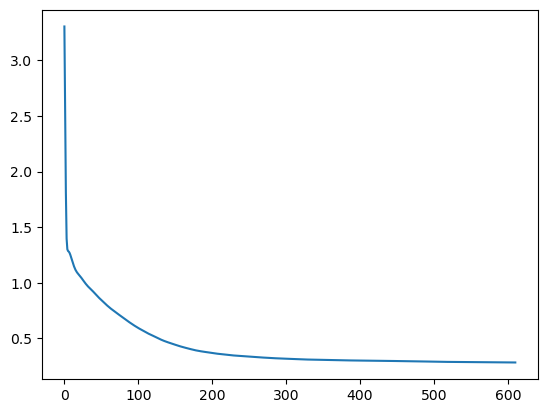

In [17]:
print(np.asarray(nnmod.head.param))
plt.plot(alg.lvals)
plt.show()

In [18]:
def calc_zz(mod, min_val, max_val):
    xrange = np.linspace(min_val, max_val, 201)
    yrange = np.linspace(min_val, max_val, 201)
    XX, YY = np.meshgrid(xrange, yrange)
    XY = np.c_[XX.ravel(), YY.ravel()]
    ZZ = mod.evaluate(XY)
    ZZ = ZZ.reshape(XX.shape)
    return ZZ

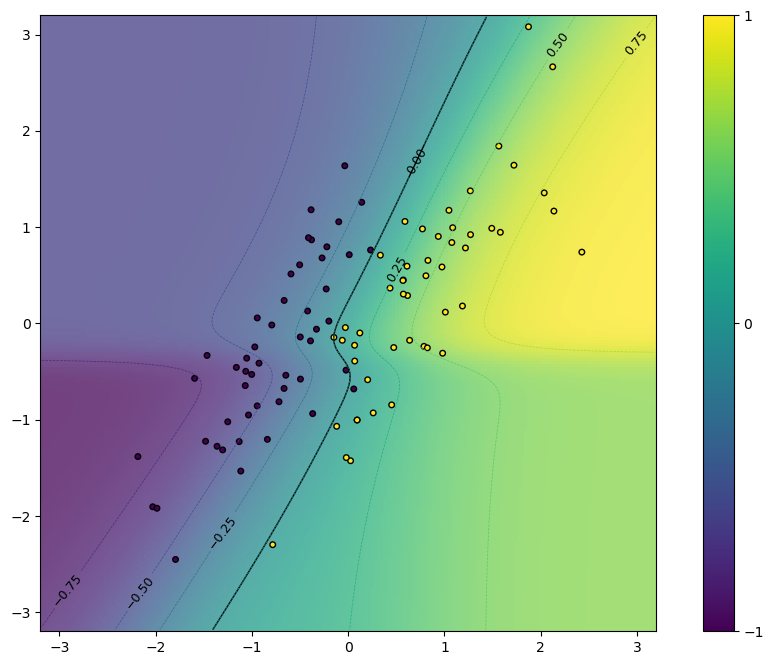

In [19]:
ZZ = calc_zz(nnmod, -3.2, 3.2)
plt.figure(figsize=(12,8))
cs = plt.scatter(U2[:,0], U2[:,1], c=Y2, edgecolors='k', s=16)
plt.imshow(ZZ, origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), alpha=0.75)
plt.colorbar(cs, ticks=[-1,0,1])
plt.contour(ZZ, levels=[0], origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), linewidths=1, colors='k')
cn = plt.contour(ZZ, origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), linewidths=0.5, linestyles='--')
plt.clabel(cn, colors='k', fontsize=9)
# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.show()

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
accuracy_score(Y2, np.sign(nnmod.evaluate(U2)))

0.99

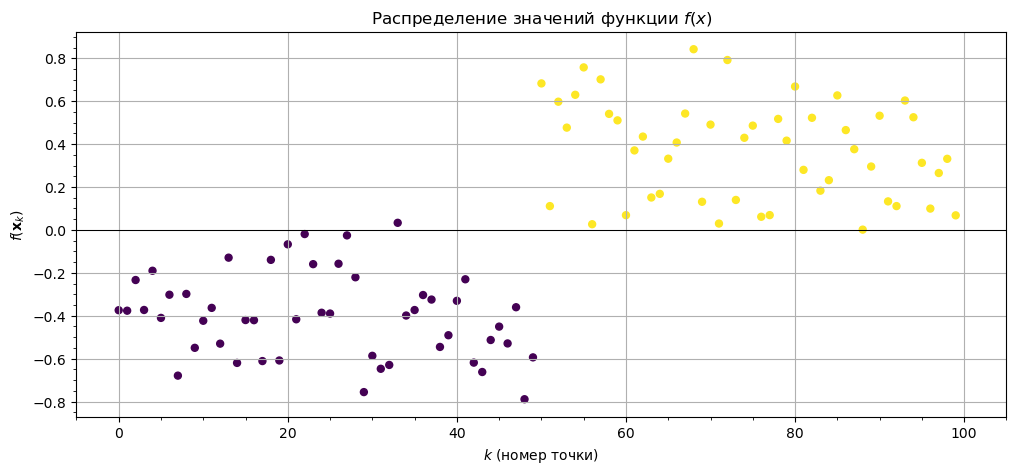

In [22]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(nnmod, U2, Y2)
plt.show()

In [23]:
P = np.asarray(nnmod.body.param)

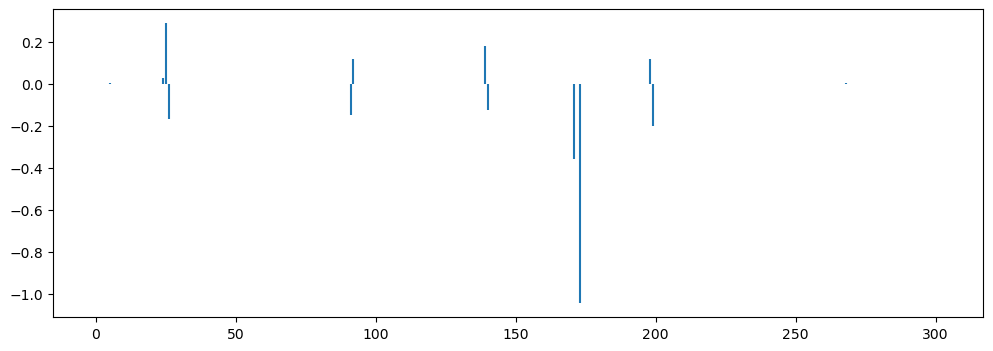

In [24]:
plt.figure(figsize=(12,4))
I_m = P>0; P_m = P.copy(); P_m[I_m] = 0
I_p = P<0; P_p = P.copy(); P_p[I_p] = 0
plt.vlines(range(len(P)), P_m, P_p)
plt.show()